In [1]:
# Intialize the tensorflow-gpu <-> physical matching

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [2]:
from load.load_data import load_opendata
from load.load_data import load_mydata

import matplotlib.pyplot as plt
%matplotlib inline
import random

In [4]:
openloader = load_opendata()
X_open, Y_open = openloader.load_data(classifier_label=None, dsize=(64,64), comp_ratio=4)

myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="OOP", dsize=(64,64), comp_ratio=10)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="OOP", dsize=(64,64), comp_ratio=4)

print("Open data is ", len(X_open),", My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

Test_data without Label: 100%|██████████| 79726/79726 [01:37<00:00, 818.16it/s]


My data folder lists are..
20211012_center_belt_nomask_minseok1
20211012_center_unbelt_nomask_minseok1
20211015_center_belt_mask_yukhyun1
20211015_center_unbelt_mask_sungwook1
20211015_center_unbelt_mask_yukhyun1
20211015_center_unbelt_nomask_sungwook1
20211015_center_unbelt_nomask_sungwook2
20211015_center_unbelt_nomask_yukhyun1
20211015_close_unbelt_nomask_sungwook1
20211017_center_belt_mask_yukhyun1
20211017_center_belt_nomask_yukhyun1
20211017_center_unbelt_mask_sungwook1
20211017_center_unbelt_nomask_sungwook1
20211019_center_belt_mask_juwon1
20211019_center_belt_mask_juwon2
20211019_center_belt_mask_juwon3
20211019_center_belt_nomask_juwon1
20211019_center_belt_nomask_juwon2
20211019_center_unbelt_mask_juwon3
20211019_center_unbelt_nomask_juwon1
20211019_close_belt_mask_juwon1
20211019_close_unbelt_mask_juwon1
20211019_far_belt_mask_juwon1
20211019_far_unbelt_mask_juwon1
20211019_phone_belt_mask_juwon1
20211019_phone_unbelt_mask_juwon1
20211020_behind_belt_mask_sujin1
20211020_be

My data Loading with OOP: 24821it [00:05, 4442.72it/s]


Test data folder lists are..
20211012_center_belt_nomask_minseok1
20211012_center_unbelt_nomask_minseok1
20211015_center_belt_mask_yukhyun1
20211015_center_unbelt_mask_sungwook1
20211015_center_unbelt_mask_yukhyun1
20211015_center_unbelt_nomask_sungwook1
20211015_center_unbelt_nomask_sungwook2
20211015_center_unbelt_nomask_yukhyun1
20211015_close_unbelt_nomask_sungwook1
20211017_center_belt_mask_yukhyun1
20211017_center_belt_nomask_yukhyun1
20211017_center_unbelt_mask_sungwook1
20211017_center_unbelt_nomask_sungwook1
20211019_center_belt_mask_juwon1
20211019_center_belt_mask_juwon2
20211019_center_belt_mask_juwon3
20211019_center_belt_nomask_juwon1
20211019_center_belt_nomask_juwon2
20211019_center_unbelt_mask_juwon3
20211019_center_unbelt_nomask_juwon1
20211019_close_belt_mask_juwon1
20211019_close_unbelt_mask_juwon1
20211019_far_belt_mask_juwon1
20211019_far_unbelt_mask_juwon1
20211019_phone_belt_mask_juwon1
20211019_phone_unbelt_mask_juwon1
20211020_behind_belt_nomask_sujin1
2021102

Test data Loading with OOP: 2000it [00:01, 1023.68it/s]

Open data is  19932 , My Train set is  1025 ,  My Test set is  358


In [5]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import random_rotation, random_shift, random_zoom

# Data Augmentation (5%=5%)
aug_X = []
for i in range(int(0.05*len(X_open))):
    data_aug_idx = random.randrange(0, len(X_open)-1)
    img=random_rotation(X_open[data_aug_idx], rg=80, row_axis=0, col_axis=1, channel_axis=2)
    aug_X.append(img)

    data_aug_idx = random.randrange(0, len(X_open)-1)
    img=random_shift(X_open[data_aug_idx], wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2)
    aug_X.append(img)

    data_aug_idx = random.randrange(0, len(X_open)-1)
    img=random_zoom(X_open[data_aug_idx], zoom_range=[0.6,0.9], row_axis=0, col_axis=1, channel_axis=2)
    aug_X.append(img)

X = np.concatenate((X_open, np.array(aug_X)))

print("Image samples with augmentation are" , X.shape)

# Shuffled Image
random.shuffle(X)

# Normalized Image
X = np.array(X)/255.0

Image samples with augmentation are (22920, 64, 64, 3)


In [6]:
# Train, Val, Test Split
from sklearn.model_selection import train_test_split

X_train = X[:int(len(X)*0.75)]
X_val = X[int(len(X)*0.75):]

print(X_train.shape)
print(X_val.shape)

(17190, 64, 64, 3)
(5730, 64, 64, 3)


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import model.model_autoencoder
from model.model_autoencoder import model_autoencoder
import importlib
importlib.reload(model.model_autoencoder)

import tensorflow as tf
import os


def scheduler(epoch, lr):
    if epoch in [5,9,12,20]:
        lr = 0.1*lr
    return lr
    
autoencoder = model_autoencoder(input_shape = (64, 64, 3))
adam = Adam(learning_rate=0.001)
ls_callback = LearningRateScheduler(scheduler)
es_callback = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience=3)
filepath = os.path.join(os.getcwd(), "ckpt/", "Autoencoder-{epoch:01d}-{val_loss:.2f}.h5")
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

autoencoder.compile(loss = 'mse', optimizer = adam)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
enc_1st_conv (Conv2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
enc_1st_relu (ReLU)          (None, 64, 64, 64)        0         
_________________________________________________________________
enc_1st_maxpool (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
enc_2nd_conv (Conv2D)        (None, 32, 32, 128)       204928    
_________________________________________________________________
enc_2nd_relu (ReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
enc_2nd_maxpool (MaxPooling2 (None, 16, 16, 128)       0     

In [8]:
autoencoder.fit(x=X_train, y = X_train, epochs=30, batch_size=32, shuffle=True, validation_data=(X_val, X_val), callbacks=[ls_callback, es_callback, checkpoint])

Epoch 1/30
538/538 [==============================] - 1450s 3s/step - loss: 0.1960 - val_loss: 0.1047

Epoch 00001: val_loss improved from inf to 0.10473, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Autoencoder-1-0.10.h5
Epoch 2/30
538/538 [==============================] - 1466s 3s/step - loss: 0.1033 - val_loss: 0.1028

Epoch 00002: val_loss improved from 0.10473 to 0.10284, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Autoencoder-2-0.10.h5
Epoch 3/30
538/538 [==============================] - 1378s 3s/step - loss: 0.0901 - val_loss: 0.0807

Epoch 00003: val_loss improved from 0.10284 to 0.08066, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Autoencoder-3-0.08.h5
Epoch 4/30
538/538 [==============================] - 1354s 3s/step - loss: 0.0502 - val_loss: 0.0449

Epoch 00004: val_loss improved from 0.08066 to 0.04494, saving model to /home/joke

In [9]:
# Save Model
autoencoder.save('./ckpt/model_oop_autoencoder')

INFO:tensorflow:Assets written to: ./ckpt/model_oop_autoencoder/assets


In [91]:
# Display the train data and a version of it with added noise
predictions = autoencoder.predict(aug_noise_X_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

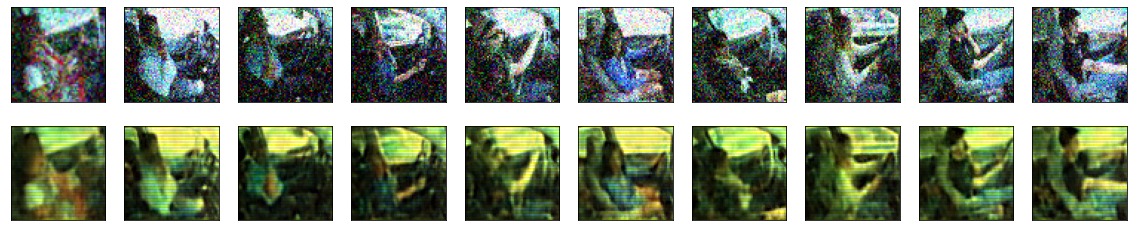

(115, 64, 64, 3) (115, 64, 64, 3)


In [96]:
display_pair(aug_noise_X_val, predictions)

In [87]:
noise_X_val = noise(X_val[0:100])
aug_noise_X_val = augment(noise_X_val)

In [88]:
aug_noise_X_val.shape

(115, 64, 64, 3)

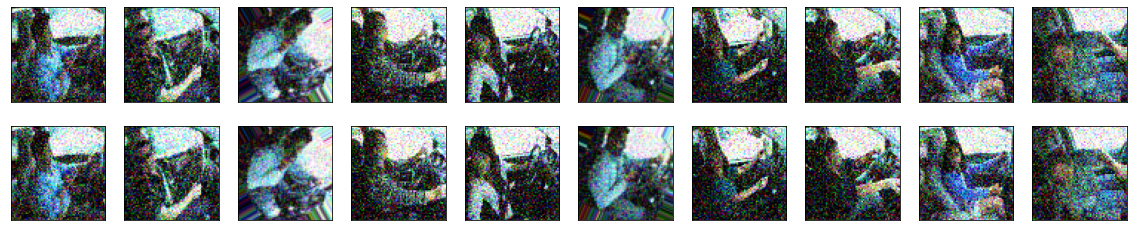

(115, 64, 64, 3) (115, 64, 64, 3)


In [90]:
display(aug_noise_X_val, aug_noise_X_val)

In [85]:
def preprocess(array, shape):
    """
    Normalizes the supplied array and reshpaed it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), shape[0],shape[1],shape[2]))
    return array

def noise(array):
    """
    Adds random noise to each images in the supplied array.
    """

    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(size=array.shape)

    return np.clip(noisy_array, 0.0, 1.0)

def augment(array, ratio = 0.05):
    """
    Adds random augment to each images in the supplied array as ratio%
    """

    aug_X = []
    for i in range(int(ratio*len(array))):
        data_aug_idx = random.randrange(0, len(array)-1)
        img=random_rotation(array[data_aug_idx], rg=80, row_axis=0, col_axis=1, channel_axis=2)
        aug_X.append(img)

        data_aug_idx = random.randrange(0, len(array)-1)
        img=random_shift(array[data_aug_idx], wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2)
        aug_X.append(img)

        data_aug_idx = random.randrange(0, len(array)-1)
        img=random_zoom(array[data_aug_idx], zoom_range=[0.6,0.9], row_axis=0, col_axis=1, channel_axis=2)
        aug_X.append(img)

    aug_X = np.array(aug_X)
    return np.concatenate((array, aug_X), axis=0)

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def tsne_plot(x1, labels_as_one_column, fig_title=None):
    """
    tsne analysis for viewing
    """

    x1 = x1.reshape(x1.shape[0], -1)
    print("Before Shape is: ", x1.shape)

    pca_50 = PCA(n_components = 50)
    pca_results_50 = pca_50.fit_transform(x1)

    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(pca_results_50)

    print("After Shape is: ", X_t.shape)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[:, 0], X_t[:, 1], s= 5, c=labels_as_one_column, cmap='Spectral')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    
    plt.legend(loc='best')
    plt.title(fig_title)
    plt.show()

def display_pair(array1, array2, label=None):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size = n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    if label is not None:
        print("Label: " , np.array(label[indices]))

    plt.figure(figsize=(20,4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n , i+1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2,n, i+1+n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
    print(array1.shape, array2.shape)